In [1]:
import pandas as pd
import numpy as np
import random
import time
import os
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('../input/september-folds/train_folds.csv')
df_test = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
sample_solution = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv')

useful_features = [c for c in df.columns if c not in ("id", "claim", "KFold")]
numerical_cols = [col for col in useful_features if col.startswith("f")]
df_test = df_test[useful_features]

In [3]:
lgb_params = {
    'learning_rate': 0.015332061170550073,
    'reg_lambda': 1.103077586535056,
    'reg_alpha': 32.904819081261586,
    'subsample': 0.6863733858469923,
    'colsample_bytree': 0.8915690246247586,
    'max_depth': 5
}

In [4]:
lgb_pred = np.zeros(df_test.shape[0])
lgb_importances = pd.DataFrame()

for fold in range(5):
    print(fold)
    xtrain =  df[df.KFold != fold].reset_index(drop = True)
    xvalid = df[df.KFold == fold].reset_index(drop = True)
    xtest = df_test.copy()

    ytrain = xtrain.claim
    yvalid = xvalid.claim
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    model = lgb.LGBMClassifier(
        n_estimators = 7500,
        objective = 'binary',
        **lgb_params
    )
    
    model.fit(
        xtrain, 
        ytrain,
        eval_set = [(xvalid, yvalid)],
        eval_metric = 'auc',
        early_stopping_rounds = 300,
        verbose = False,
    )
    
    # This block is only for finding the importances of each feature
    res = pd.DataFrame()
    res['feature'] = model.feature_name_
    res['importance'] = model.feature_importances_
    res['fold'] = fold
    res['seed'] = 42
    lgb_importances = lgb_importances.append(res)
    
    valid_preds = model.predict_proba(xvalid)[:, -1]
    lgb_pred += model.predict_proba(xtest)[:, -1] / 5
    auc = roc_auc_score(yvalid, valid_preds)
    print(fold, auc)

0
0 0.8016263309828153
1
1 0.8035430062833645
2
2 0.8021433388772523
3
3 0.80385576316306
4
4 0.7956252180508973


['f40', 'f47', 'f70', 'f35', 'f34', 'f77', 'f3', 'f57', 'f21', 'f5', 'f96', 'f45', 'f8', 'f65', 'f106', 'f1', 'f95', 'f31', 'f27', 'f7', 'f16', 'f62', 'f13', 'f107', 'f28', 'f52', 'f42', 'f92', 'f46', 'f36', 'f9', 'f75', 'f6', 'f24', 'f15', 'f109', 'f78', 'f2', 'f99', 'f71', 'f48', 'f25', 'f30', 'f69', 'f61', 'f11', 'f50', 'f79', 'f53', 'f86', 'f97', 'f38', 'f32', 'f60', 'f114', 'f110', 'f108', 'f103', 'f12', 'f81', 'f102', 'f104', 'f111', 'f54', 'f39', 'f49', 'f44', 'f10', 'f113', 'f73', 'f17', 'f43', 'f84', 'f112', 'f55', 'f90', 'f33', 'f37', 'f87', 'f91', 'f68', 'f83', 'f105', 'f115', 'f41', 'f18', 'f118', 'f29', 'f98', 'f64', 'f94', 'f19', 'f80', 'f116', 'f23', 'f4', 'f59', 'f14', 'f56', 'f51', 'f22', 'f93', 'f66', 'f88', 'f82', 'f117', 'f100', 'f63', 'f58', 'f72', 'f20', 'f101', 'f89', 'f76', 'f74', 'f67', 'f26', 'f85']


Text(0.5, 1.0, 'LightGBM feature importances')

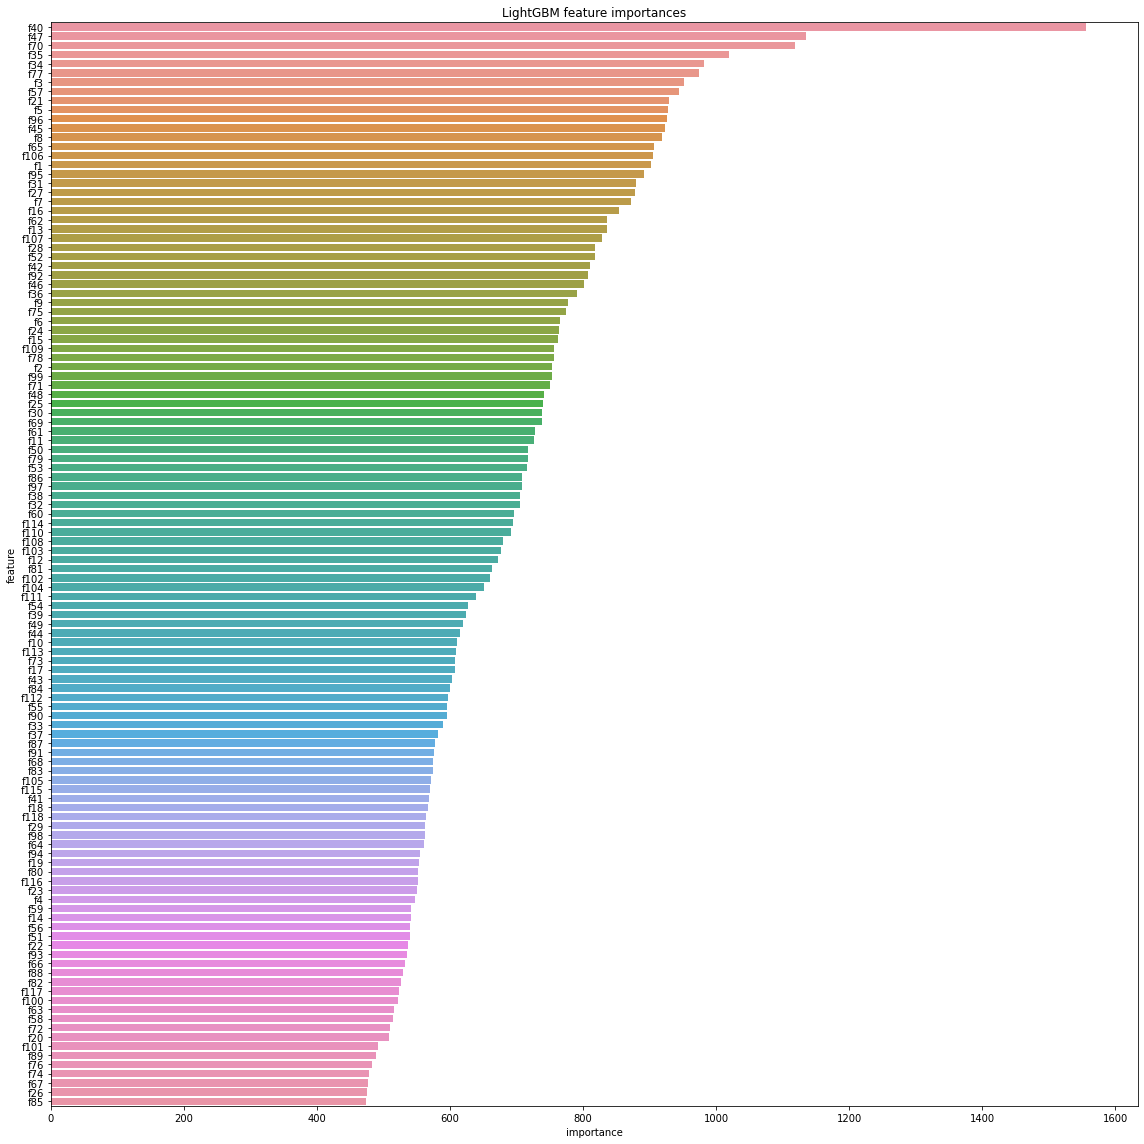

In [5]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending = False).index)

print(order)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x = "importance", y = "feature", 
            data = lgb_importances.groupby('feature').mean().reset_index(), 
            order = order)
plt.title("LightGBM feature importances")

In [6]:
sample_solution['claim'] = lgb_pred
sample_solution.to_csv("submission.csv", index = False)
sample_solution

,id,claim
0,957919,0.411118
1,957920,0.267758
2,957921,0.447738
3,957922,0.295510
4,957923,0.330348
...,...,...
493469,1451388,0.580654
493470,1451389,0.289240
493471,1451390,0.821463
493472,1451391,0.320835
